# Predictive coding in an N-dim. network

This notebook simulates an example network of three neurons encoding a one-dimensional signal.

## Header definitions

Besides packages, we also load Flat UI's base colors for plotting.

In [608]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from numpy import linalg as LA
from matplotlib.legend_handler import HandlerLine2D
from scipy.interpolate import UnivariateSpline
import matplotlib.image as mpimg
import math
import svgutils.transform as sg
import sys 
import os
%matplotlib inline
VERBOSE = False                     # Printout

### base colors (flat ui)
bcolors = { 'alizarin'   : "#e74c3c",
            'peter_river': "#3498db",
            'emerald'    : "#2ecc71",
            'sunflower'  : "#f1c40f",
            'carrot'     : "#e67e22",
            'amethyst'   : "#9b59b6",
            'turquoise'  : "#1abc9c",
            'wet_asphalt': "#34495e",
            'pomegranate': "#c0392b",
            'belize_hole': "#2980b9"
        }
rcolors = plt.get_cmap('rainbow', N)

## Special plot functions

Here we define plot functions used later in this notebook.

### multiplot

The multiplot function takes an array of one-dimensional signals to be plotted (for time series in same plot).

### rasterplot

Creates a spike raster plot for given spike train and time array.

### rasterplot_half

Like rasterplot, but spikes are spaced (for placing membrane potential below). Option to add population spikes.

### hide_ax

Returns axes without right-upper borders.

In [609]:
def multiplot(ax,x,arr):
    if len(arr) > 10:
        colors = plt.get_cmap('rainbow', len(arr))
    else:
        colors = list(bcolors.values())
    for i, y in enumerate(arr):
        if len(arr) > 10:
            ax.plot(x, y, '-', c=colors(i))
        else:
            ax.plot(x, y, '-', c=colors[i])
    return ax

def rasterplot(ax, time, spikes):
    N = len(spikes)
    if N > 10:
        colors = plt.get_cmap('rainbow', N)
    else:
        colors = list(bcolors.values())
    for neuron in range(N):
        posy = (1+neuron)*spikes[neuron, spikes[neuron,:]==1]
        if N > 10:
            ax.vlines(time[spikes[neuron,:]==1], posy-0.5, posy+0.5, colors=colors(neuron))
        else:
            ax.vlines(time[spikes[neuron,:]==1], posy-0.5, posy+0.5, colors=colors[neuron])
    ax.set_ylim([0, N+1])
    ax.set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    ax.set_yticks(np.arange(spacer,N+1,spacer))
    return ax

def rasterplot_half(ax, time, spikes, pos=[0.25, 0.6], pop=True):
    N = len(spikes)
    pop_spikes = np.sum(spikes, axis=0)
    dt = time[1]
    if N > 10:
        colors = plt.get_cmap('rainbow', N)
    else:
        colors = list(bcolors.values())
    for neuron in range(N):
        posy = (1+neuron)*spikes[neuron, spikes[neuron,:]==1]
        if N > 10:
            ax.vlines(time[spikes[neuron,:]==1], posy+pos[0], posy+pos[1], colors=colors(neuron), lw=2)
        else:
            ax.vlines(time[spikes[neuron,:]==1], posy+pos[0], posy+pos[1], colors=colors[neuron], lw=2)
    if pop:        
        if N > 10:
            ax.vlines(time[pop_spikes==1], N+0.75, N+1.25, colors='k', lw=2)
        else:
            ax.vlines(time[pop_spikes==1], N+0.75, N+1.25, colors='k', lw=2)        
        ax.set_ylim([0, N+2])
    else:
        ax.set_ylim([0, N+1])
    ax.set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    ax.set_yticks(np.arange(spacer,N+1,spacer))
    return ax

def hide_ax(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    return ax

## Plot time series for a given simulation

Contains signal/decoder & membrane potentials with spikes, as well as population spikes.

In [610]:
### Plot time series for 1D signal (example)
def plot_time_series(time, signal, readout, spikes, rates, volt, F, W, t):
    figs = 2
    fig, axes = plt.subplots(figs, 1, figsize=(5,5),sharex=True)
    csignal = signal + np.hstack((0, np.diff(signal)/dt))

    ### additional measures
    pop_rate   = np.mean(rates, axis=0)  # population activity
    pop_var    = np.var(rates, axis=0)   # population variance
    pop_spikes = np.sum(spikes, axis=0)  # population spikes

    ### panel A: input time series
    axes[0].plot(time[t[0]:t[1]], signal[t[0]:t[1]], "-" , c=bcolors['alizarin'], label="Signal")
    axes[0].plot(time[t[0]:t[1]], readout[t[0]:t[1]], c=bcolors['belize_hole'], label="Decoder")
    lg = axes[0].legend(bbox_to_anchor=(0.7, 0.0), loc=2, borderaxespad=0.)
    lg.draw_frame(False)
    axes[0].set_ylabel("Input")
    axes[0].set_xlim([t[0]*dt,t[1]*dt])
    axes[0].axis("off")
    
    ### panel B: spike raster plot
    axes[1] = rasterplot_half(axes[1], time, spikes*dt)
    axes[1] = multiplot(axes[1], time, [(0.5*pot+ind+1) for ind, pot in enumerate(volt)])
    for i in range(3):
        axes[1].plot([t[0]*dt,t[1]*dt], [i+1.25,i+1.25],'--', c='#dddddd')                  # Thresholds
    axes[1].set_xlim([t[0]*dt,t[1]*dt])
    axes[1].set_ylim([0.5,N+1])
    axes[1].axis("off")

    return fig, axes

## Plot ISI distributions for given data

Uses Scipy UnivariateSpline to fit probability densities for ISIs. Takes array of ISIs of population and individual neurons.

In [611]:
# Plot ISI distributions of the data
def plot_isi(isis, nruns):
    fig, ax = plt.subplots(2, 1, figsize=(3,5),sharex=True)
    p, x = np.histogram(isis[0], bins=15) # bin it into n = N/10 bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
    xn = np.hstack((0, x, 1.0))
    pn = np.hstack((0, p, 0))
    pn[1] = 0
    pn[-2] =0
    g = UnivariateSpline(xn, pn/nruns, s=15)
    ax[0].plot(xn, g(xn), c='k')
    ax[0].set_xlim([0,0.1])
    ax[0].set_ylim([0,2000])
    ax[0].set_ylabel("Frequency [s$^{-1}$]")
    ax[0] = hide_ax(ax[0])

    stind = np.hstack((isis[ind] for ind in range(1, len(isis))))
    p, x = np.histogram(stind, bins=20) # bin it into n = N/10 bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers

    xn = np.hstack((0, x))
    pn = np.hstack((0, p))
    g = UnivariateSpline(xn, pn/nruns, s=20)

    ax[1].plot(xn, g(xn), c='k')
    ax[1].set_xlim([0,0.5])
    ax[1].set_ylim([0,600])
    ax[1] = hide_ax(ax[1])
    ax[1].set_xlabel("Interspike interval [s]")
    ax[1].set_ylabel("Frequency [s$^{-1}$]")
    return fig, ax

## Functions to generate input signals

In [612]:
def get_oscillat_input(time, ampl, freq, offs, noise_var = 0.0):
    x       = ampl * np.sin(freq*time) + offs            # define input array
    x      += noise_var*rand.randn(len(time))          # adding zero-mean white noise
    return x

def get_step_input(time, ontimes, offtimes, ampl, tau, noise_var = 0.0):
    x       = np.zeros(len(time))             # define input array
    c       = 0
    dt = time[1]
    for ind,t in enumerate(time[:-1]):
        if t in ontimes:
            c += ampl
        if t in offtimes:
            c -= ampl
        dx = -x[ind] + c
        if tau > 0.0:
            x[ind+1] = x[ind]+dt*tau*dx
        else:
            x[ind+1] = x[ind] + dx
    x      += noise_var*rand.randn(len(time)) # adding zero-mean white noise
    return x

def get_const_input(time, ampl, noise_var = 0.0):
    return get_step_input(time, [0.000], [], ampl, 0.0)

def get_rand_input(time, ampl, tau):
    x       = np.zeros(len(time))             # define input array
    c       = 0
    dt = time[1]
    for ind,t in enumerate(time[:-1]):
        c  = ampl*rand.randn()
        dx = -x[ind] + c
        x[ind+1] = x[ind]+dt*tau*dx 
    x[1:] += 2
    return x

## Function to run simulation

In [613]:
def run(N, time, signal=0.0):
    """ This function simulates an N-dim. network for a given time
    
        RETURNS
        o      === spike trains of each neuron               || (nparray)
        st     === spike times and indices (for ISI)         || (nparray)
        V      === membrane potentials of each neuron        || (nparray)
        y      === spike trains of each neuron               || (nparray)
        r      === firing rates                              || (nparray)
        F      === feed-forward weights (fixed)              || (nparray)
        Fo     === initial feed-forward weights              || (nparray)
        W      === recurrent weights (adapted)               || (nparray)
        D      === decoding weights (fixed)                  || (nparray)
        
        ARGS
        N      === number of neurons in network              || (int)
        time   === time array                                || (nparray)
        signal === input (default:0.0)                       || (float)
        
    """
    
    ### Quick options
    _COST     = True                                         # use quadratic cost term
    _MULTI    = True                                         # multirun
    
    
    ### time
    dt = time[1]-time[0]                                     # integration time step
    T  = dt*len(time)                                        # total duration
    
    
    ### state containers
    V  = np.zeros((N,len(time)))                             # membrane potential
    o  = np.zeros((N,len(time)))                             # spike trains
    r  = np.zeros((N,len(time)))                             # firing rates
    y  = np.zeros(len(time))                                 # readout
    st = []                                                  # spike times + index    
    
    
    ### input from args
    x  = signal                                              # input signal
    if isinstance(x, float):                                 # if float is given
        x *= np.ones(len(time))                              # make sure input is correct dims
    
    
    ### network weights and firing threshold
    
    ## FEED-FORWARD
    F       = np.ones(N)                                     # feed-forward connections
    F      *= 1.0                                            # scaling
    Fo      = np.copy(F)                                     # initial weights
    
    ## RECURRENT
    mu      = 0.000001/N if _COST else 0.0                   # regularization constant (e-6)
    Fmat    = F.reshape(N,1)
    W       = Fmat.dot(Fmat.T) + mu * np.eye(N)                    # optimal weights
    W      *= 1.                                             # scaling
    
    ## DECODING
    D       = np.zeros((1,N))                                # decoder weights
    d1      = np.zeros((1,N))            
    d2      = 0.0
    
    
    ### constant parameters
    Thr     = (F*F)/2 + (mu/2)*np.ones(N)    # thresholds
    Thr     = 0.5*np.ones(N)
    leak = 1.                                                # leak constant
    
    if VERBOSE:
        evals, evecs = LA.eigh(W)
        print("Feed-forward weights:", F)
        print("Recurrent weights:", W)
        print("Spectral radius:", evals)
        print("Threshold:", Thr)
     
    ### ablations
    nabl    = 4                                              # number of ablations
    tabl    = 1000.                                          # start of ablations
    ablen   = 0.5                                            # duration of ablations
    ablate_t= (np.arange(tabl, tabl+ablen, ablen/nabl))/dt        # ablation times (start at halftime in short window)
    ablate_t= ablate_t.astype(int)
    ablate_t = []#[int(45.)/dt]
    if VERBOSE:
        print("Ablations at t=", ablate_t*dt,"secs.")
    ablated = []
    to_ablate = []
    
    ### initial values
    V[:,0]  = -Thr
    
    ### running simulation
    if not _MULTI:
        print("Start simulation for", time[-1]+time[1],"seconds.")
    for i,t in enumerate(time[:-1]):
        
        ## ablations
        for ind, times in enumerate(ablate_t):
            if i == times:
                if len(to_ablate)==0:
                    rand_neuron = rand.randint(N)
                    while rand_neuron in ablated:
                        rand_neuron = rand.randint(N)
                else:
                    if ind < len(to_ablate):
                        rand_neuron = to_ablate[ind]
                if rand_neuron not in ablated:
                    F, W, V[:,i] = ablate_neuron(rand_neuron,i, F, W, V[:,i])
                    ablated.append(rand_neuron)
        
        ## input update
        c = x[i] + (x[i+1]-x[i])/dt                                            # neural input
        
        ## membrane potential update
        dV       = -V[:,i] + F*c - W.dot(o[:,i])                               # ODE membrane potential
        V[:,i+1] = V[:,i] + dt*leak*dV                                         # Euler integration
        
        ## spikes update
        o[:,i+1] = (V[:,i+1] > Thr)                                            # check for spikes
        if np.sum(o[:,i+1])>0:
            special_flake = rand.choice(np.ravel(np.nonzero(o[:,i+1])), 1)[0]  # look who's a special flake...
            o[:,i+1]      = np.eye(N)[special_flake]/dt                        # only one spike per time step
            st.append([t, special_flake])
              
        ## firing rates update
        dr       = -r[:,i] + o[:,i+1]                                          # ODE firing rates
        r[:,i+1] = r[:,i] + dt*leak*dr                                         # Euler integration

        ## regular printouts (every 10%)
        if math.fmod(100*t/T,10)==0 and not _MULTI:
            print(int(100*t/T), "%\t", "t:",t, "s")
            
    
    ### Calculate optimal decoding weights
    Finv1 = LA.pinv(Fo.reshape(N,1))
    Finv2 = LA.pinv(F.reshape(N,1))
    htime = int(tabl/dt)
    #D = F.T
            
    ### Calculate readouts
    if htime < T: 
        D1 = np.dot(Finv1,W_all[htime])
        D2 = np.dot(Finv2,W)
        y[:,:htime]   = D1.dot(r[:,:htime])
        y[:,htime+1:] = D2.dot(r[:,htime+1:])
    else:
        D  = np.dot(Finv2,W)
        D  = F.T
        y  = D.dot(r)
        
        
    ### Return
    if not _MULTI:
        print(100, "%\t", "t:",T, "s")
        print("Done.")
        print("Spikes/time:", np.sum(o)/(N*T))
    st = np.array(st)
    return o, st, V, y, r, F, Fo, W, D 

## Run first simulation (step function input) for Fig 1B

In [614]:
" Step function input "
### simulation parameter
N    = 3                   # number of neurons
T    = 10.                # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array

### generate step function input signal
ampl = 1.5
step = get_step_input(time, [2., 6.], [], ampl, 10.)

### run simulation
o, st, V, y, r, ffW, ffWo, recW, decW = run(N, time, step)

## Plot Figure 1B (time series)

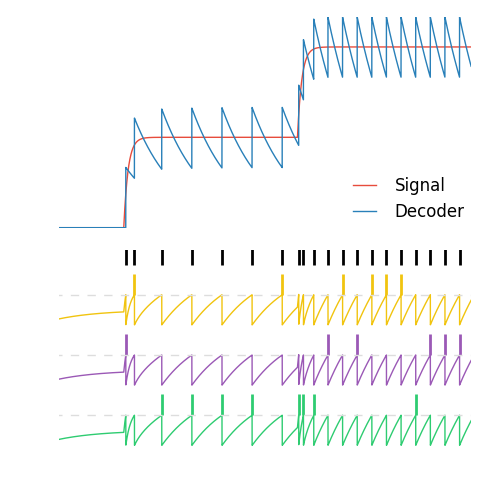

In [615]:
f, ax = plot_time_series(time, step, y, o, r, V, ffW, recW, [0, int(T/dt)])
lg = ax[0].legend(loc=4, borderaxespad=0.)
lg.draw_frame(False)
plt.xlim([0.5,10])
plt.tight_layout()
f.savefig("./plots/Fig1AB.svg", dpi=900)
plt.show()

## Run second simulation (random input) for Fig 1C

In [616]:
" Random input "
### simulation parameter
N    = 3                   # number of neurons
T    = 10.                # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array

### generate random input signal
ampl = 50.
tau  = .5
#rand_walk = get_rand_input(time, ampl, tau)    ## comment if you want to keep same random input

### run simulation
o, st, V, y, r, ffW, ffWo, recW, decW = run(N, time, rand_walk)

## Plot Figure 1C (time series)

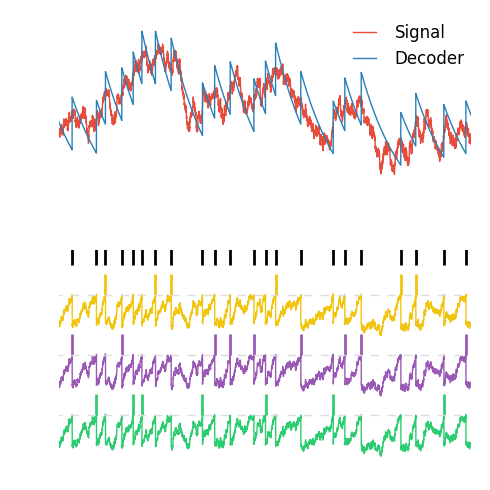

In [617]:
f, ax = plot_time_series(time, rand_walk, y, o, r, V, ffW, recW, [0, int(T/dt)])
lg = ax[0].legend(loc=1, borderaxespad=0.)
lg.draw_frame(False)
#ax[0].set_title("C", fontsize=18, loc='left', x=0.0)
#ax[1].set_title("D", fontsize=18, loc='left', x=0.0)
#ax[2].set_ylim([-100, 100])
#ax[2].axis("on")
plt.xlim([0.5,10])
plt.tight_layout()
f.savefig("./plots/Fig1CD.svg", dpi=900)
plt.show()

## Run simulations with constant input to calculate ISI distributions

In [618]:
" ISI statistics for constant input"
### simulation parameter
runs = 40
N    = 3                   # number of neurons
T    = 10.                # total duration
dt   = 0.001               # integration time step
time = np.arange(0, T, dt) # time array
stall = [np.zeros(100000), np.zeros(100000), np.zeros(100000), np.zeros(100000)]
count = [0, 0, 0, 0]
start = [0, 0, 0, 0]
end   = [0, 0, 0, 0]


for irun in range(runs):
    ### generate random input signal
    ampl = 20.
    const_in = get_step_input(time, [0.], [9.], ampl, 100.)

    ### run simulation
    o, st, V, y, r, ffW, ffWo, recW, decW = run(N, time, const_in)
    
    ### remove transients
    st = st[20:]
    
    tst = []
    tst.append(np.round(st,2))
    tst.append(st[st[:,1]==0])
    tst.append(st[st[:,1]==1])
    tst.append(st[st[:,1]==2])
    
    diffs = []
    diffs.append(np.diff(tst[0][:,0]))
    diffs.append(np.diff(tst[1][:,0]))
    diffs.append(np.diff(tst[2][:,0]))
    diffs.append(np.diff(tst[3][:,0]))
    ### append spikes
    for ind in range(4):
        start[ind] = count[ind]
        end[ind] = count[ind]+diffs[ind].shape[0]
        stall[ind][start[ind]:end[ind]] = diffs[ind]
        count[ind] += diffs[ind].shape[0]
for ind in range(4):
    stall[ind].resize(count[ind])

## Plot Figure 1D & E (ISI distributions)

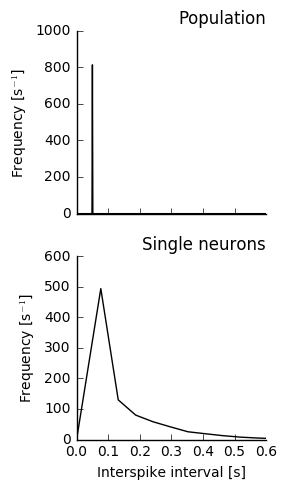

In [619]:
f, ax = plot_isi(stall, runs/5)
ax[0].set_title("Population", fontsize=12, loc='right')
ax[0].set_ylim([0,1000])
ax[1].set_title("Single neurons", fontsize=12, loc='right')
plt.xlim([0,0.6])
plt.tight_layout()
f.savefig("./plots/Fig1EF.svg", dpi=900)
plt.show()

## Join panels together into Figure 1 (using SVGs)

Output size: 1046px 360px


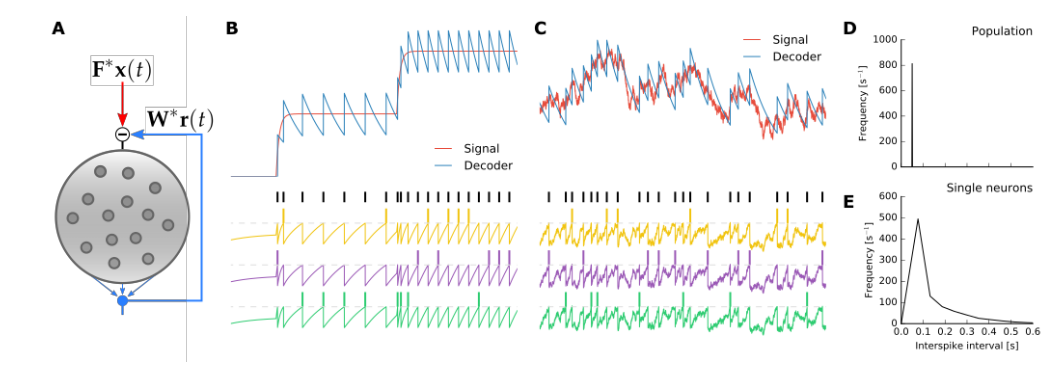

In [620]:
def toInt(string):
    return int(string.replace("pt", ""))

" join figures together "
#create new SVG figure
fig = sg.SVGFigure("1500px", "500px")

# load matpotlib-generated figures
curr_dir = "/Users/degoldschmidt/workspace/network-rotation/plots"
fig0 = sg.fromfile(curr_dir + "/sketch.svg")
fig1 = sg.fromfile(curr_dir + "/Fig1AB.svg")
fig2 = sg.fromfile(curr_dir + '/Fig1CD.svg')
fig3 = sg.fromfile(curr_dir + '/Fig1EF.svg')

# get the plot objects
plot0 = fig0.getroot()
plot1 = fig1.getroot()
wid0, hei0 = fig0.get_size()
wid0, hei0 = toInt(wid0), toInt(hei0)
wid, hei = fig1.get_size()
wid, hei = toInt(wid), toInt(hei)
wid2, hei2 = fig3.get_size() 
wid2, hei2 = toInt(wid2), toInt(wid2)
plot2 = fig2.getroot()
plot3 = fig3.getroot()
plot1.moveto(-30+wid0, 0)
plot2.moveto(wid-70+wid0, 0)
plot3.moveto(2*wid-70+wid0, 0)
newwid = 2*wid+wid2-70+wid0

newwid = str(newwid)+"px"
newhei = str(hei)+"px"
print("Output size:",newwid, newhei)
fig.set_size([newwid, newhei])


# add text labels
fsize = 18
offs = 20
txt0 = sg.TextElement(offs-10,offs, "A", size=fsize, weight="bold")
txt1 = sg.TextElement(offs-10+wid0,offs, "B", size=fsize, weight="bold")
txt2 = sg.TextElement(wid-30+wid0,offs, "C", size=fsize, weight="bold")
txt3 = sg.TextElement(2*wid-70+wid0,offs, "D", size=fsize, weight="bold")
txt4 = sg.TextElement(2*wid-70+wid0,hei/2+offs, "E", size=fsize, weight="bold")

# append plots and labels to figure
fig.append([plot3, plot2, plot1, plot0])
fig.append([txt0, txt1, txt2, txt3, txt4])

# save generated SVG files
fig.save(curr_dir + "/Fig1.svg")
# svg-to-pdf conversion using Inkscape
inkscape = "/Applications/Inkscape.app/Contents/Resources/script --without-gui"
folder = "/Users/degoldschmidt/workspace/network-rotation/plots/"
filesvg = folder + "Fig1.svg"
filepdf = folder + "Fig1.pdf"
filepng = folder + "Fig1pre.png"
os.system(inkscape + " --export-pdf=" + filepdf + " " + filesvg)
os.system(inkscape + " --export-png=" + filepng + " " + filesvg)
# show preview png
plt.figure(figsize=(13,5))
image = mpimg.imread(filepng)
plt.imshow(image)
plt.axis("off")
plt.show()